# **Olympic Medal Prediction**

## Importing Libraries


In [0]:
athlete_event = spark.read.format("csv").option("header","true").option("inferSchema","true").load("/FileStore/tables/athlete_events-2.csv")

In [0]:
#Setting up the for the dataset
import os

In [0]:
# Importing all the required packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import mlflow
import tensorflow as tf
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

2024-04-25 17:29:29.897965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Reading Dataset

In [0]:
data=athlete_event.toPandas()
data.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24,180,80,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NA
1,2,A Lamusi,M,23,170,60,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NA
2,3,Gunnar Nielsen Aaby,M,24,NA,NA,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NA
3,4,Edgar Lindenau Aabye,M,34,NA,NA,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21,185,82,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NA


In [0]:
data.replace('NA', pd.NA, inplace=True)

In [0]:
data.dropna()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
40,16,Juhamatti Tapio Aaltonen,M,28,184,85,Finland,FIN,2014 Winter,2014,Winter,Sochi,Ice Hockey,Ice Hockey Men's Ice Hockey,Bronze
41,17,Paavo Johannes Aaltonen,M,28,175,64,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Individual All-Around,Bronze
42,17,Paavo Johannes Aaltonen,M,28,175,64,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Team All-Around,Gold
44,17,Paavo Johannes Aaltonen,M,28,175,64,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Horse Vault,Gold
48,17,Paavo Johannes Aaltonen,M,28,175,64,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Pommelled Horse,Gold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271078,135553,Galina Ivanovna Zybina (-Fyodorova),F,25,168,80,Soviet Union,URS,1956 Summer,1956,Summer,Melbourne,Athletics,Athletics Women's Shot Put,Silver
271080,135553,Galina Ivanovna Zybina (-Fyodorova),F,33,168,80,Soviet Union,URS,1964 Summer,1964,Summer,Tokyo,Athletics,Athletics Women's Shot Put,Bronze
271082,135554,Bogusaw Zych,M,28,182,82,Poland,POL,1980 Summer,1980,Summer,Moskva,Fencing,"Fencing Men's Foil, Team",Bronze
271102,135563,Olesya Nikolayevna Zykina,F,19,171,64,Russia,RUS,2000 Summer,2000,Summer,Sydney,Athletics,Athletics Women's 4 x 400 metres Relay,Bronze


In [0]:
print(data.isna().sum())

ID             0
Name           0
Sex            0
Age         9472
Height     59999
Weight     62857
Team         186
NOC            6
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     230893
dtype: int64


In [0]:
data

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24,180,80,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,<NA>
1,2,A Lamusi,M,23,170,60,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,<NA>
2,3,Gunnar Nielsen Aaby,M,24,<NA>,<NA>,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,<NA>
3,4,Edgar Lindenau Aabye,M,34,<NA>,<NA>,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21,185,82,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29,179,89,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,<NA>
271112,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",<NA>
271113,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",<NA>
271114,135571,Tomasz Ireneusz ya,M,30,185,96,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,<NA>


In [0]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ID      271116 non-null  int32 
 1   Name    271116 non-null  object
 2   Sex     271116 non-null  object
 3   Age     261644 non-null  object
 4   Height  211117 non-null  object
 5   Weight  208259 non-null  object
 6   Team    270930 non-null  object
 7   NOC     271110 non-null  object
 8   Games   271116 non-null  object
 9   Year    271116 non-null  object
 10  Season  271116 non-null  object
 11  City    271116 non-null  object
 12  Sport   271116 non-null  object
 13  Event   271116 non-null  object
 14  Medal   40223 non-null   object
dtypes: int32(1), object(14)
memory usage: 30.0+ MB


In [0]:
# seeing group summary of season cloumn
data['Season'].value_counts()

Summer         222024
Winter          48419
1952               55
1972               54
1960               50
1964               48
1948               47
1968               46
1956               38
1992               35
1988               35
1984               33
1936               29
1976               27
1932               25
1996               22
1928               21
1908               15
1924               12
1920               10
1912                9
1904                7
2012                6
1994                5
1980                5
2000                5
2002                4
2010                4
1998                3
2014                3
2004                3
2016                3
2008                3
1936 Summer         3
1900                2
1932 Summer         2
1906                1
1988 Summer         1
2006                1
1900 Summer         1
Name: Season, dtype: int64

In [0]:
# seeing group summary of Medal cloumn
data['Medal'].value_counts()

Gold                                                13254
Bronze                                              13236
Silver                                              13060
Ice Hockey Men's Ice Hockey                            22
Basketball Men's Basketball                            16
                                                    ...  
Polo Men's Polo                                         1
Shooting Men's Running Target, 10 metres                1
Beach Volleyball Men's Beach Volleyball                 1
Swimming Women's 800 metres Freestyle                   1
Shooting Men's Running Target, Single Shot, Team        1
Name: Medal, Length: 219, dtype: int64

In [0]:
# seeing group summary of Event cloumn
data['Event'].value_counts()

Football Men's Football          5728
Ice Hockey Men's Ice Hockey      4740
Hockey Men's Hockey              3952
Water Polo Men's Water Polo      3354
Basketball Men's Basketball      3264
                                 ... 
Polo                                1
Aeronautics Mixed Aeronautics       1
Paris                               1
Beach Volleyball                    1
Seoul                               1
Name: Event, Length: 811, dtype: int64

In [0]:
# seeing group summary of Team cloumn
data['Team'].value_counts()

United States    17372
France           11983
Great Britain    11389
Italy            10260
Germany           9303
                 ...  
Jeannette-18         1
Turquoise-1          1
Calimucho            1
Nadine               1
Digby                1
Name: Team, Length: 1246, dtype: int64

In [0]:
data.dropna(subset=['Age'], inplace=True)

In [0]:
data.dropna(subset=['Team'], inplace=True)

In [0]:
data.dropna(subset=['NOC'], inplace=True)

In [0]:
data.dropna(subset=['Year'], inplace=True)

In [0]:
print(data.isna().sum())

ID             0
Name           0
Sex            0
Age            0
Height     51402
Weight     54079
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     222153
dtype: int64


## Exploratory Data Analysis

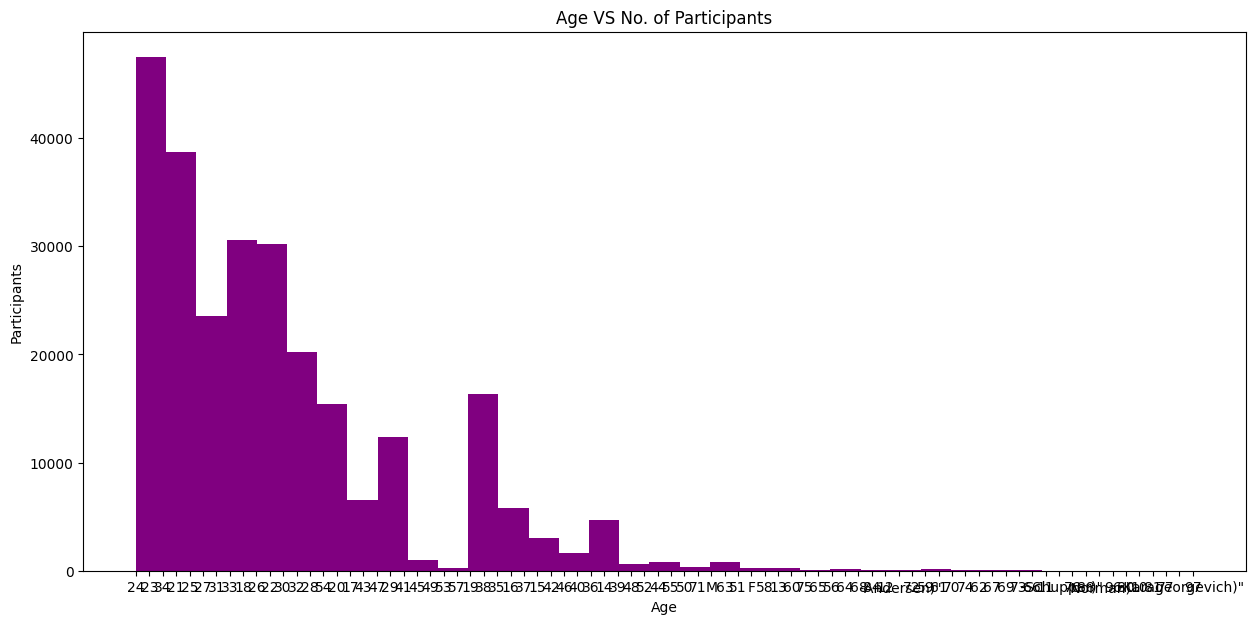

In [0]:
# Age Distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.title("Age VS No. of Participants")
plt.hist(data.Age, color='purple', bins=35)
plt.xlabel("Age")
plt.ylabel("Participants")
plt.show()

In [0]:
# Age to participant distribution
age_dist = data.Age.value_counts().sort_values(ascending=False).head(15)
age_dist

23    21813
24    21676
22    20755
25    19660
21    19100
26    17631
27    15999
20    15223
28    14017
19    11602
29    11435
30     9464
18     8130
31     7542
32     6229
Name: Age, dtype: int64

Most of the athletes are in between Age group 20 to 30


In [0]:
# Gender Distribution
gender_unique_values = data.Sex.value_counts()
gender_unique_values

M               187037
F                73934
 Jr."              355
 III"               79
 Sr."               31
                 ...  
 -Berlin)"           1
 -Williams)"         1
 -Henseler)"         1
 -Brandt)"           1
 -Clarke)"           1
Name: Sex, Length: 76, dtype: int64

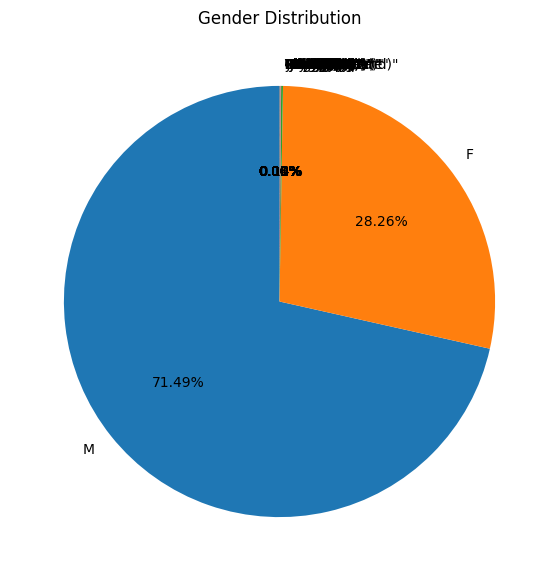

In [0]:
plt.figure(figsize=(15,7))
plt.title("Gender Distribution")
plt.pie(gender_unique_values, labels=gender_unique_values.index, autopct="%.2f%%", startangle=90)
plt.show()

Here, We observe that male participants are more than female participants in the olympics

In [0]:
# seeing female participants in each year in summer season

female_part = data[(data.Sex=='F') & (data.Season == 'Summer')][['Sex', 'Year']]
female_part = female_part.groupby('Year').count().reset_index()
female_part

,Year,Sex
0,1900,23
1,1904,13
2,1906,4
3,1908,39
4,1912,87
5,1920,121
6,1924,189
7,1928,338
8,1932,306
9,1936,437


Text(0, 0.5, 'Female Participants')

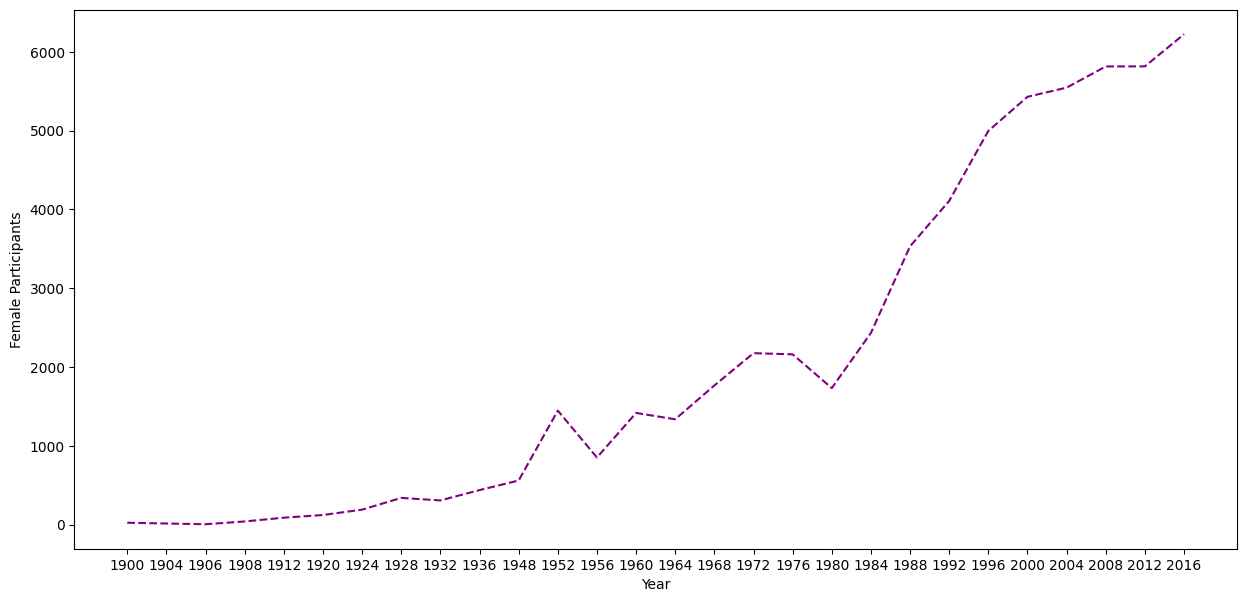

In [0]:
# Visualizing the female participant data

plt.figure(figsize=(15,7))
sns.lineplot(data=female_part, x='Year', y='Sex', linestyle = '--', color = 'purple')
plt.xlabel('Year')
plt.ylabel('Female Participants')

We can see that Female Participants have increased by a great extent since 1960's

In [0]:
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')
data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
data['Height'] = pd.to_numeric(data['Height'], errors='coerce')


In [0]:
# Participants across the season

seasons = data.Season.value_counts()
seasons

Summer         212837
Winter          48134
1952               55
1972               54
1960               50
1964               48
1948               47
1968               46
1956               38
1992               35
1988               35
1984               33
1936               29
1976               27
1932               25
1996               22
1928               21
1908               15
1924               12
1920               10
1912                9
1904                7
2012                6
1994                5
1980                5
2000                5
2002                4
2010                4
1998                3
2014                3
2004                3
2016                3
2008                3
1936 Summer         3
1900                2
1932 Summer         2
1906                1
1988 Summer         1
2006                1
1900 Summer         1
Name: Season, dtype: int64

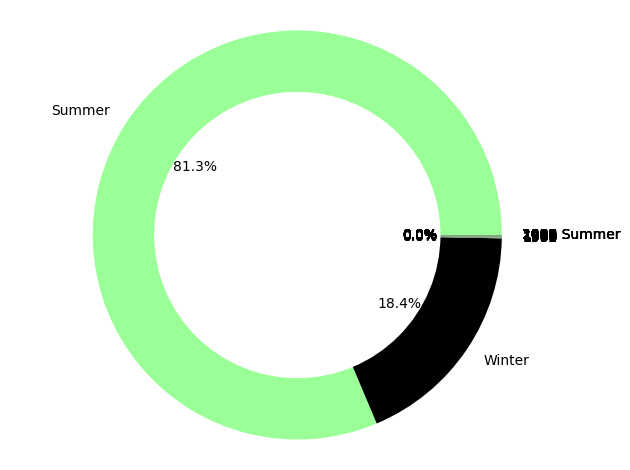

In [0]:
# Visualizing paritipant distribution in different season
fig1, ax1 = plt.subplots()

colors = ['#99ff96','#000000']

ax1.pie(seasons, colors = colors, labels=seasons.index, autopct='%1.1f%%')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.show()

Participation in summer season is more than the winter season

In [0]:
# Top 15 Countries participating in Olympics by no. of participants
top_countries = data.Team.value_counts().sort_values(ascending=False).head(15)
top_countries

United States    17136
France           10872
Great Britain    10717
Italy             9922
Germany           9157
Canada            9075
Japan             8173
Sweden            8041
Australia         7396
Hungary           6407
Poland            6125
Netherlands       5700
Switzerland       5514
Soviet Union      5430
Finland           5378
Name: Team, dtype: int64

<AxesSubplot:title={'center':'Top 15 Countries Total Participations'}, ylabel='Team'>

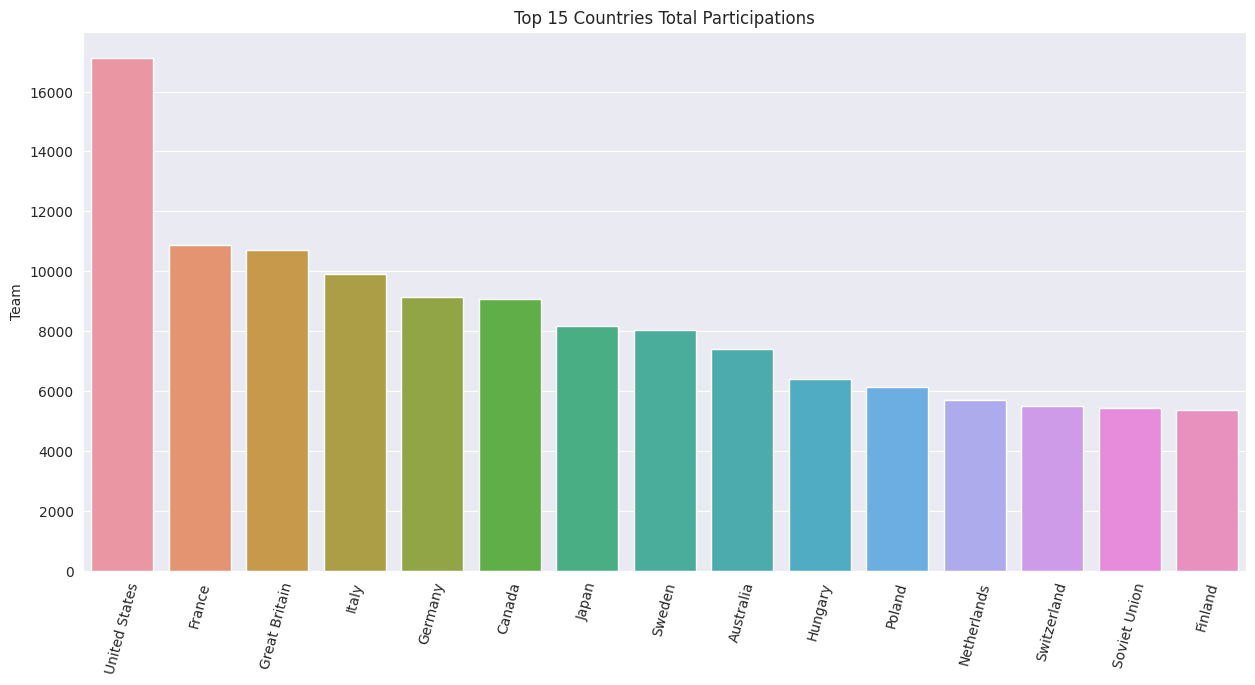

In [0]:
# Data Visualization of countries participating
sns.set_style('darkgrid')
plt.figure(figsize=(15, 7))
plt.title('Top 15 Countries Total Participations')
plt.xticks(rotation=75)
sns.barplot(x=top_countries.index, y=top_countries)

In [0]:
# Data of countries with most Gold medals

max_year_country = data[(data.Medal == 'Gold')].Team
max_year_country = max_year_country.value_counts().head(20)
max_year_country


United States    2375
Soviet Union     1058
Germany           675
Italy             534
Great Britain     514
France            453
Sweden            449
Hungary           432
Canada            420
East Germany      369
Russia            366
Australia         340
China             308
Norway            299
Netherlands       271
Japan             247
South Korea       211
Finland           198
Denmark           168
Cuba              164
Name: Team, dtype: int64

Text(0.5, 0, 'Top 20 Gold Medal Won Countrywise')

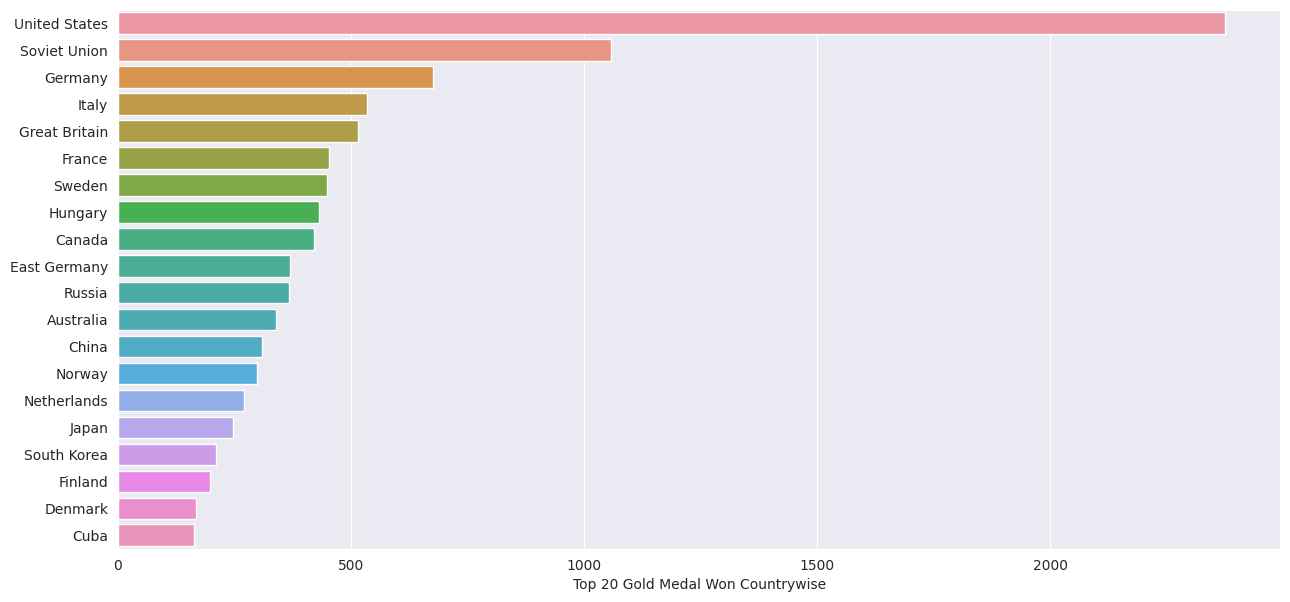

In [0]:
# Visulaizing the countries with most Gold medals
plt.figure(figsize=(15,7))
sns.barplot(x=max_year_country, y=max_year_country.index)
plt.xlabel("Top 20 Gold Medal Won Countrywise")

In [0]:
data['Medal'] = data['Medal'].fillna('No Medal')

In [0]:
# Calculate the mean of the Height column
height_mean = data['Height'].mean()

# Fill missing values in the Height column with the mean value
data['Height'] = data['Height'].fillna(height_mean)

In [0]:
# Convert 'Weight' column to numeric
data['Weight'] = pd.to_numeric(data['Weight'], errors='coerce')

# Calculate the mean of the 'Weight' column
Weight_mean = data['Weight'].mean()

# Fill missing values in the 'Weight' column with the mean value
data['Weight'] = data['Weight'].fillna(Weight_mean)


In [0]:
# Convert 'Weight' column to numeric
data['Age'] = pd.to_numeric(data['Age'], errors='coerce')

# Calculate the mean of the 'Weight' column
Age_mean = data['Age'].mean()

# Fill missing values in the 'Weight' column with the mean value
data['Age'] = data['Age'].fillna(Age_mean)


In [0]:
data.to_csv('cleaned_data.csv', index=False)

In [0]:
data.dropna(subset=['Year'], inplace=True)

In [0]:
print(data.isna().sum())

ID        0
Name      0
Sex       0
Age       0
Height    0
Weight    0
Team      0
NOC       0
Games     0
Year      0
Season    0
City      0
Sport     0
Event     0
Medal     0
dtype: int64


In [0]:
missing_medals = data['Medal'].isna()

# Number of missing values in the 'Medal' column
num_missing_medals = missing_medals.sum()

print(f"Number of missing values in the 'Medal' column: {num_missing_medals}")

Number of missing values in the 'Medal' column: 0


In [0]:

# Filter data
age_height = data[(data.Age.notnull()) & (data.Height.notnull()) & (data.Medal != 'None') & (data.Season == 'Summer')]

In [0]:
print(f"Number of rows in the filtered 'age_height' DataFrame: {len(age_height)}")

Number of rows in the filtered 'age_height' DataFrame: 169470


In [0]:
non_null_medals = data['Medal'].notnull().sum()
print(f"Number of non-null values in the 'Medal' column: {non_null_medals}")

Number of non-null values in the 'Medal' column: 261644


In [0]:
summer_games = data['Season'].eq('Summer').sum()
print(f"Number of rows where the 'Season' column is equal to 'Summer': {summer_games}")

Number of rows where the 'Season' column is equal to 'Summer': 212837


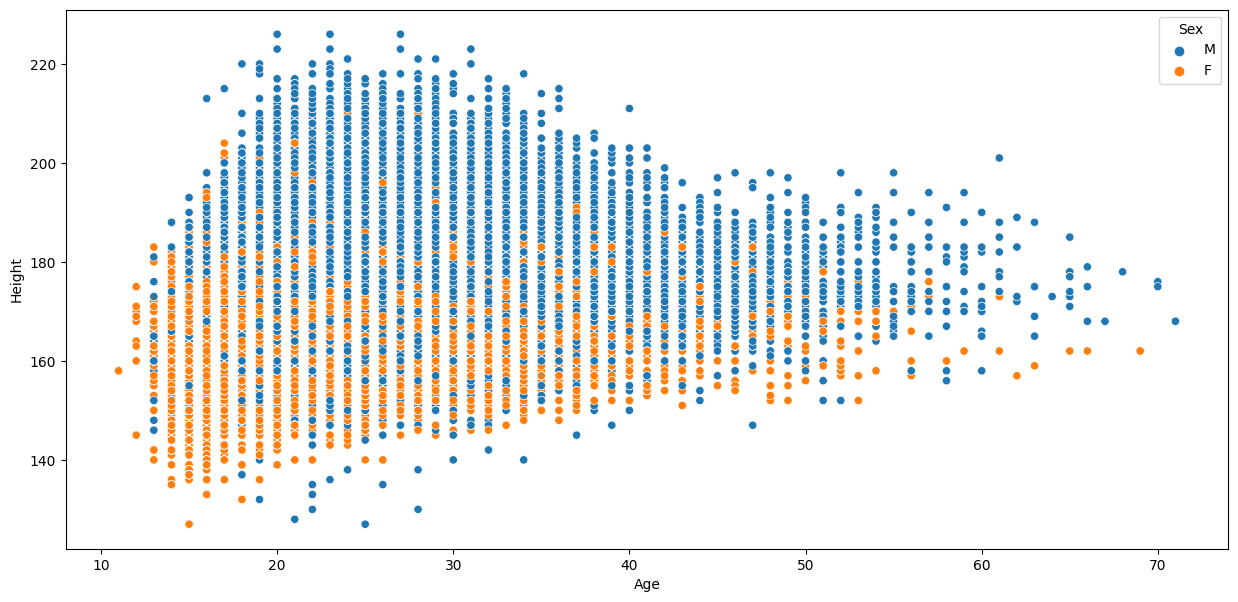

In [0]:
age_height = data[(data.Age.notnull()) & (data.Height.notnull()) & (data.Season == 'Summer')]

plt.figure(figsize=(15,7))
sns.scatterplot(x=age_height.Age, y=age_height.Height, data=age_height, hue='Sex')
plt.xlabel('Age')
plt.ylabel('Height')
plt.show()

Text(0, 0.5, 'Height')

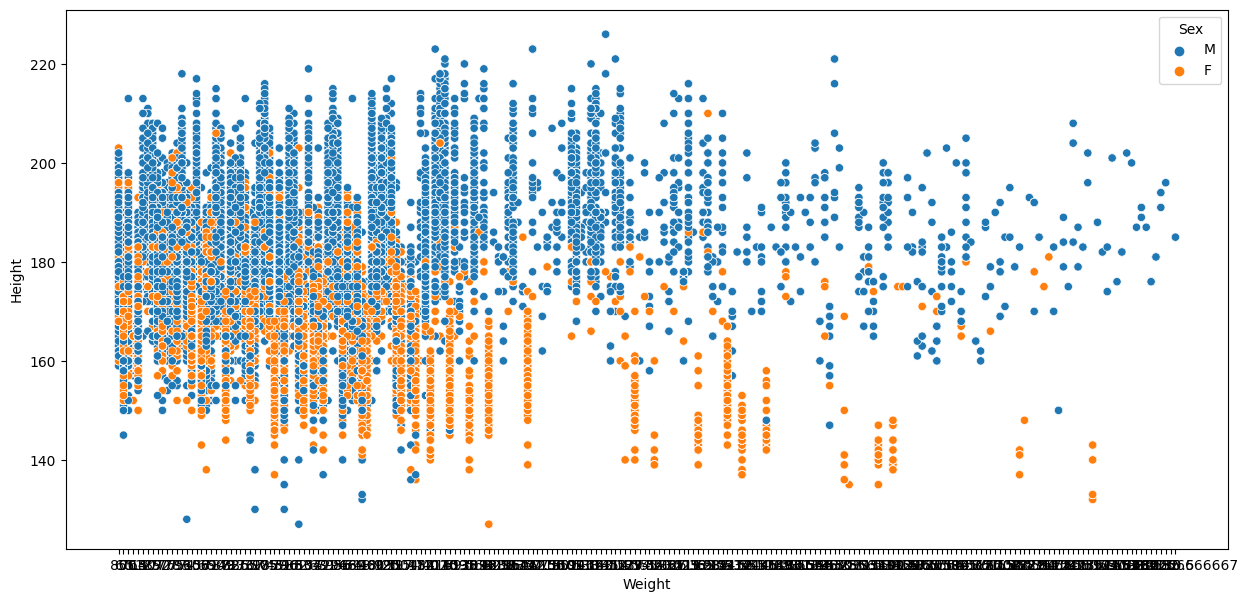

In [0]:
# Weight & Height Spread

height_weight = data[(data.Height != 0.0) & (data.Age != 0) & (data.Weight != 0.0) & (data.Medal != 'None') & (data.Season == 'Summer')]
plt.figure(figsize=(15,7))
sns.scatterplot(x=height_weight.Weight, y=height_weight.Height, data=height_weight, hue='Sex')
plt.xlabel('Weight')
plt.ylabel('Height')

## Data Cleaning

In [0]:
data.Medal.replace(['Bronze','Gold','Silver','No Medal'],[3,1,2,0],inplace=True)
data.Sex.replace(['F','M'],[1,0],inplace=True)
data.Season.replace(['Summer','Winter'],[1,0],inplace=True)

In [0]:
data

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,0,24.0,180.00000,80.000000,China,CHN,1992 Summer,1992.0,1,Barcelona,Basketball,Basketball Men's Basketball,0
1,2,A Lamusi,0,23.0,170.00000,60.000000,China,CHN,2012 Summer,2012.0,1,London,Judo,Judo Men's Extra-Lightweight,0
2,3,Gunnar Nielsen Aaby,0,24.0,174.99981,70.951585,Denmark,DEN,1920 Summer,1920.0,1,Antwerpen,Football,Football Men's Football,0
3,4,Edgar Lindenau Aabye,0,34.0,174.99981,70.951585,Denmark/Sweden,DEN,1900 Summer,1900.0,1,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,1
4,5,Christine Jacoba Aaftink,1,21.0,185.00000,82.000000,Netherlands,NED,1988 Winter,1988.0,0,Calgary,Speed Skating,Speed Skating Women's 500 metres,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,0,29.0,179.00000,89.000000,Poland-1,POL,1976 Winter,1976.0,0,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,0
271112,135570,Piotr ya,0,27.0,176.00000,59.000000,Poland,POL,2014 Winter,2014.0,0,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",0
271113,135570,Piotr ya,0,27.0,176.00000,59.000000,Poland,POL,2014 Winter,2014.0,0,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",0
271114,135571,Tomasz Ireneusz ya,0,30.0,185.00000,96.000000,Poland,POL,1998 Winter,1998.0,0,Nagano,Bobsleigh,Bobsleigh Men's Four,0


In [0]:
# Drop Uncessary feature columns
data = data.drop(['ID', 'Name', 'Games'], axis=1)

In [0]:
# Checking null values in the data 
data.isna().mean()


Sex       0.000000
Age       0.002572
Height    0.196492
Weight    0.207331
Team      0.000711
NOC       0.000023
Year      0.002572
Season    0.000000
City      0.000000
Sport     0.000000
Event     0.000000
Medal     0.000000
dtype: float64

In [0]:
# Checking null values again
print("Total missing values:", data.isna().sum().sum())


Total missing values: 0


In [0]:
data

,Sex,Age,Height,Weight,Team,NOC,Year,Season,City,Sport,Event,Medal
0,0,24.0,180.00000,80.000000,China,CHN,1992.0,1,Barcelona,Basketball,Basketball Men's Basketball,0
1,0,23.0,170.00000,60.000000,China,CHN,2012.0,1,London,Judo,Judo Men's Extra-Lightweight,0
2,0,24.0,174.99981,70.951585,Denmark,DEN,1920.0,1,Antwerpen,Football,Football Men's Football,0
3,0,34.0,174.99981,70.951585,Denmark/Sweden,DEN,1900.0,1,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,1
4,1,21.0,185.00000,82.000000,Netherlands,NED,1988.0,0,Calgary,Speed Skating,Speed Skating Women's 500 metres,0
...,...,...,...,...,...,...,...,...,...,...,...,...
271111,0,29.0,179.00000,89.000000,Poland-1,POL,1976.0,0,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,0
271112,0,27.0,176.00000,59.000000,Poland,POL,2014.0,0,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",0
271113,0,27.0,176.00000,59.000000,Poland,POL,2014.0,0,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",0
271114,0,30.0,185.00000,96.000000,Poland,POL,1998.0,0,Nagano,Bobsleigh,Bobsleigh Men's Four,0


In [0]:
# Checking no. of unique values in the column
{column: len(data[column].unique()) for column in data.select_dtypes('object').columns}

{'Team': 1108, 'NOC': 228, 'City': 42, 'Sport': 66, 'Event': 757}

In [0]:
# defining the function.
def binary_encode(df, columns, positive_values):
    df = df.copy()
    for column, positive_value in zip(columns, positive_values):
        df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [0]:
data = binary_encode(
    data,
    columns=['Sex', 'Season'],
    positive_values=['M', 'Summer']
)

data = onehot_encode(
    data,
    columns=['Team', 'NOC', 'City', 'Sport', 'Event'],
    prefixes=['T', 'N', 'C', 'S', 'E']
)

In [0]:
data

,Sex,Age,Height,Weight,Year,Season,Medal,T_30. Februar,T_A North American Team,T_Acipactli,T_Acturus,T_Afghanistan,T_Akatonbo,T_Alain IV,T_Albania,T_Alcaid,T_Aldebaran,T_Aldebaran II,T_Aletta,T_Algeria,T_Ali-Baba II,T_Ali-Baba IV,T_Ali-Baba IX,T_Ali-Baba VI,T_Allegro,T_Almaz,T_Aloha II,T_Amateur Athletic Association,T_American Samoa,T_Amolgavar,T_Amstel Amsterdam,T_Amulet-3,T_Amulet-7,T_Ancora,T_Andorinha,T_Andorra,T_Andromeda,T_Angelita,T_Angerburg,T_Angola,...,E_Weightlifting Men's Super-Heavyweight,"E_Weightlifting Men's Unlimited, One Hand","E_Weightlifting Men's Unlimited, Two Hands",E_Weightlifting Women's Featherweight,E_Weightlifting Women's Flyweight,E_Weightlifting Women's Heavyweight,E_Weightlifting Women's Light-Heavyweight,E_Weightlifting Women's Lightweight,E_Weightlifting Women's Middleweight,E_Weightlifting Women's Super-Heavyweight,"E_Wrestling Men's All-Around, Greco-Roman","E_Wrestling Men's Bantamweight, Freestyle","E_Wrestling Men's Bantamweight, Greco-Roman","E_Wrestling Men's Featherweight, Freestyle","E_Wrestling Men's Featherweight, Greco-Roman","E_Wrestling Men's Flyweight, Freestyle","E_Wrestling Men's Flyweight, Greco-Roman","E_Wrestling Men's Heavyweight, Freestyle","E_Wrestling Men's Heavyweight, Greco-Roman","E_Wrestling Men's Light-Flyweight, Freestyle","E_Wrestling Men's Light-Flyweight, Greco-Roman","E_Wrestling Men's Light-Heavyweight, Freestyle","E_Wrestling Men's Light-Heavyweight, Greco-Roman","E_Wrestling Men's Lightweight, Freestyle","E_Wrestling Men's Lightweight, Greco-Roman","E_Wrestling Men's Middleweight A, Greco-Roman","E_Wrestling Men's Middleweight B, Greco-Roman","E_Wrestling Men's Middleweight, Freestyle","E_Wrestling Men's Middleweight, Greco-Roman","E_Wrestling Men's Super-Heavyweight, Freestyle","E_Wrestling Men's Super-Heavyweight, Greco-Roman","E_Wrestling Men's Unlimited Class, Greco-Roman","E_Wrestling Men's Welterweight, Freestyle","E_Wrestling Men's Welterweight, Greco-Roman","E_Wrestling Women's Featherweight, Freestyle","E_Wrestling Women's Flyweight, Freestyle","E_Wrestling Women's Heavyweight, Freestyle","E_Wrestling Women's Light-Heavyweight, Freestyle","E_Wrestling Women's Lightweight, Freestyle","E_Wrestling Women's Middleweight, Freestyle"
0,0,24.0,180.00000,80.000000,1992.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,23.0,170.00000,60.000000,2012.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,24.0,174.99981,70.951585,1920.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,34.0,174.99981,70.951585,1900.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,21.0,185.00000,82.000000,1988.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,0,29.0,179.00000,89.000000,1976.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
271112,0,27.0,176.00000,59.000000,2014.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
271113,0,27.0,176.00000,59.000000,2014.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [0]:
# Spilt data in target column and features columns
y = data['Medal']
X = data.drop('Medal', axis=1)

In [0]:
print(y==0)

0          True
1          True
2          True
3         False
4          True
          ...  
271111     True
271112     True
271113     True
271114     True
271115     True
Name: Medal, Length: 260971, dtype: bool


In [0]:
X.shape

(260971, 2207)

In [0]:
y.shape

(260971,)

In [0]:
X

,Sex,Age,Height,Weight,Year,Season,T_30. Februar,T_A North American Team,T_Acipactli,T_Acturus,T_Afghanistan,T_Akatonbo,T_Alain IV,T_Albania,T_Alcaid,T_Aldebaran,T_Aldebaran II,T_Aletta,T_Algeria,T_Ali-Baba II,T_Ali-Baba IV,T_Ali-Baba IX,T_Ali-Baba VI,T_Allegro,T_Almaz,T_Aloha II,T_Amateur Athletic Association,T_American Samoa,T_Amolgavar,T_Amstel Amsterdam,T_Amulet-3,T_Amulet-7,T_Ancora,T_Andorinha,T_Andorra,T_Andromeda,T_Angelita,T_Angerburg,T_Angola,T_Anitra,...,E_Weightlifting Men's Super-Heavyweight,"E_Weightlifting Men's Unlimited, One Hand","E_Weightlifting Men's Unlimited, Two Hands",E_Weightlifting Women's Featherweight,E_Weightlifting Women's Flyweight,E_Weightlifting Women's Heavyweight,E_Weightlifting Women's Light-Heavyweight,E_Weightlifting Women's Lightweight,E_Weightlifting Women's Middleweight,E_Weightlifting Women's Super-Heavyweight,"E_Wrestling Men's All-Around, Greco-Roman","E_Wrestling Men's Bantamweight, Freestyle","E_Wrestling Men's Bantamweight, Greco-Roman","E_Wrestling Men's Featherweight, Freestyle","E_Wrestling Men's Featherweight, Greco-Roman","E_Wrestling Men's Flyweight, Freestyle","E_Wrestling Men's Flyweight, Greco-Roman","E_Wrestling Men's Heavyweight, Freestyle","E_Wrestling Men's Heavyweight, Greco-Roman","E_Wrestling Men's Light-Flyweight, Freestyle","E_Wrestling Men's Light-Flyweight, Greco-Roman","E_Wrestling Men's Light-Heavyweight, Freestyle","E_Wrestling Men's Light-Heavyweight, Greco-Roman","E_Wrestling Men's Lightweight, Freestyle","E_Wrestling Men's Lightweight, Greco-Roman","E_Wrestling Men's Middleweight A, Greco-Roman","E_Wrestling Men's Middleweight B, Greco-Roman","E_Wrestling Men's Middleweight, Freestyle","E_Wrestling Men's Middleweight, Greco-Roman","E_Wrestling Men's Super-Heavyweight, Freestyle","E_Wrestling Men's Super-Heavyweight, Greco-Roman","E_Wrestling Men's Unlimited Class, Greco-Roman","E_Wrestling Men's Welterweight, Freestyle","E_Wrestling Men's Welterweight, Greco-Roman","E_Wrestling Women's Featherweight, Freestyle","E_Wrestling Women's Flyweight, Freestyle","E_Wrestling Women's Heavyweight, Freestyle","E_Wrestling Women's Light-Heavyweight, Freestyle","E_Wrestling Women's Lightweight, Freestyle","E_Wrestling Women's Middleweight, Freestyle"
0,0,24.0,180.00000,80.000000,1992.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,23.0,170.00000,60.000000,2012.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,24.0,174.99981,70.951585,1920.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,34.0,174.99981,70.951585,1900.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,21.0,185.00000,82.000000,1988.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,0,29.0,179.00000,89.000000,1976.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
271112,0,27.0,176.00000,59.000000,2014.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
271113,0,27.0,176.00000,59.000000,2014.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Feature Selection

In [0]:
selector = SelectKBest(score_func=chi2, k=100)  # Select top 100 features based on chi-square test


In [0]:
fit = selector.fit(X,y)

In [0]:
data_scores=pd.DataFrame(fit.scores_)
data_columns=pd.DataFrame(X.columns)

In [0]:
print(data_scores)

                0
0             NaN
1      254.702692
2      802.380711
3     3689.350448
4      588.686405
...           ...
2202     4.547411
2203     5.592686
2204     1.512901
2205     4.789205
2206     4.547411

[2207 rows x 1 columns]


In [0]:
# Join the two dataframes
scores=pd.concat([data_columns,data_scores],axis=1)
scores.columns=['Feature','Score']
print(scores.nlargest(11,'Score'))


                  Feature        Score
1326                N_URS  4271.422071
915        T_Soviet Union  4226.283149
1328                N_USA  4090.929525
3                  Weight  3689.350448
1029      T_United States  3686.474038
1427             S_Rowing  1353.936066
1189                N_GDR  1164.308869
1344          C_Antwerpen  1060.791985
287        T_East Germany  1024.596387
1428              S_Rugby  1016.967882
1904  E_Rugby Men's Rugby  1016.967882


In [0]:
# Select 10 features
features=scores["Feature"].tolist()[:10]
features

['Sex',
 'Age',
 'Height',
 'Weight',
 'Year',
 'Season',
 'T_30. Februar',
 'T_A North American Team',
 'T_Acipactli',
 'T_Acturus']

## Make new dataset with cleaned data

In [0]:
y = data['Medal']
X = data.drop(['Medal'], axis=1)

#Split data into training and testing data
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=42)


In [0]:
y

0         0
1         0
2         0
3         1
4         0
         ..
271111    0
271112    0
271113    0
271114    0
271115    0
Name: Medal, Length: 260971, dtype: int64

In [0]:
X

,Sex,Age,Height,Weight,Year,Season,T_30. Februar,T_A North American Team,T_Acipactli,T_Acturus,T_Afghanistan,T_Akatonbo,T_Alain IV,T_Albania,T_Alcaid,T_Aldebaran,T_Aldebaran II,T_Aletta,T_Algeria,T_Ali-Baba II,T_Ali-Baba IV,T_Ali-Baba IX,T_Ali-Baba VI,T_Allegro,T_Almaz,T_Aloha II,T_Amateur Athletic Association,T_American Samoa,T_Amolgavar,T_Amstel Amsterdam,T_Amulet-3,T_Amulet-7,T_Ancora,T_Andorinha,T_Andorra,T_Andromeda,T_Angelita,T_Angerburg,T_Angola,T_Anitra,...,E_Weightlifting Men's Super-Heavyweight,"E_Weightlifting Men's Unlimited, One Hand","E_Weightlifting Men's Unlimited, Two Hands",E_Weightlifting Women's Featherweight,E_Weightlifting Women's Flyweight,E_Weightlifting Women's Heavyweight,E_Weightlifting Women's Light-Heavyweight,E_Weightlifting Women's Lightweight,E_Weightlifting Women's Middleweight,E_Weightlifting Women's Super-Heavyweight,"E_Wrestling Men's All-Around, Greco-Roman","E_Wrestling Men's Bantamweight, Freestyle","E_Wrestling Men's Bantamweight, Greco-Roman","E_Wrestling Men's Featherweight, Freestyle","E_Wrestling Men's Featherweight, Greco-Roman","E_Wrestling Men's Flyweight, Freestyle","E_Wrestling Men's Flyweight, Greco-Roman","E_Wrestling Men's Heavyweight, Freestyle","E_Wrestling Men's Heavyweight, Greco-Roman","E_Wrestling Men's Light-Flyweight, Freestyle","E_Wrestling Men's Light-Flyweight, Greco-Roman","E_Wrestling Men's Light-Heavyweight, Freestyle","E_Wrestling Men's Light-Heavyweight, Greco-Roman","E_Wrestling Men's Lightweight, Freestyle","E_Wrestling Men's Lightweight, Greco-Roman","E_Wrestling Men's Middleweight A, Greco-Roman","E_Wrestling Men's Middleweight B, Greco-Roman","E_Wrestling Men's Middleweight, Freestyle","E_Wrestling Men's Middleweight, Greco-Roman","E_Wrestling Men's Super-Heavyweight, Freestyle","E_Wrestling Men's Super-Heavyweight, Greco-Roman","E_Wrestling Men's Unlimited Class, Greco-Roman","E_Wrestling Men's Welterweight, Freestyle","E_Wrestling Men's Welterweight, Greco-Roman","E_Wrestling Women's Featherweight, Freestyle","E_Wrestling Women's Flyweight, Freestyle","E_Wrestling Women's Heavyweight, Freestyle","E_Wrestling Women's Light-Heavyweight, Freestyle","E_Wrestling Women's Lightweight, Freestyle","E_Wrestling Women's Middleweight, Freestyle"
0,0,24.0,180.00000,80.000000,1992.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,23.0,170.00000,60.000000,2012.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,24.0,174.99981,70.951585,1920.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,34.0,174.99981,70.951585,1900.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,21.0,185.00000,82.000000,1988.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,0,29.0,179.00000,89.000000,1976.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
271112,0,27.0,176.00000,59.000000,2014.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
271113,0,27.0,176.00000,59.000000,2014.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Feature Scaling

In [0]:
# Scaling data 
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [0]:
train_x.shape

(156582, 2207)

In [0]:
train_y.shape

(156582,)

In [0]:
test_x.shape

(104389, 2207)

In [0]:
test_y.shape

(104389,)

## Predictive Modeling

Logistic Regression

In [0]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Apply feature selection
selector = SelectKBest(chi2, k=100)  # Select top 100 features based on chi-square test
train_x_selected = selector.fit_transform(train_x, train_y)
test_x_selected = selector.transform(test_x)

# Train logistic regression model
log_reg = LogisticRegression()
log_reg.fit(train_x_selected, train_y)

# Make predictions
log_reg_predict = log_reg.predict(test_x_selected)

# Evaluate model
log_reg_acc_score = accuracy_score(test_y, log_reg_predict)
log_reg_conf_matrix = confusion_matrix(test_y, log_reg_predict)

print("Accuracy of Logistic Regression:", log_reg_acc_score * 100)
print("Confusion matrix:")
print(log_reg_conf_matrix)
print("\nClassification Report:")
print(classification_report(test_y, log_reg_predict))


/databricks/python/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Accuracy of Logistic Regression: 85.40842425926103
Confusion matrix:
[[88931    73     3     2]
 [ 4984   204    10     0]
 [ 4879   146    21     0]
 [ 5082    53     0     1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     89009
           1       0.43      0.04      0.07      5198
           2       0.62      0.00      0.01      5046
           3       0.33      0.00      0.00      5136

    accuracy                           0.85    104389
   macro avg       0.56      0.26      0.25    104389
weighted avg       0.80      0.85      0.79    104389



In [0]:
# Train Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(train_x_selected, train_y)

# Make predictions
nb_predict = nb.predict(test_x_selected)

# Evaluate model
nb_acc_score = accuracy_score(test_y, nb_predict)
nb_conf_matrix = confusion_matrix(test_y, nb_predict)

print("Accuracy of Multinomial Naive Bayes:", nb_acc_score * 100)
print("Confusion matrix:")
print(nb_conf_matrix)
print("\nClassification Report:")
print(classification_report(test_y, nb_predict))

Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Accuracy of Multinomial Naive Bayes: 85.47835499908994
Confusion matrix:
[[88915    74     9    11]
 [ 4916   244    38     0]
 [ 4870   107    69     0]
 [ 5042    78    14     2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     89009
           1       0.49      0.05      0.09      5198
           2       0.53      0.01      0.03      5046
           3       0.15      0.00      0.00      5136

    accuracy                           0.85    104389
   macro avg       0.51      0.26      0.26    104389
weighted avg       0.79      0.85      0.79    104389



In [0]:
# 3. Decision Tree 

algo3 = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=10,max_depth = 30)
dt.fit(train_x_selected,train_y)
dt_predicted = dt.predict(test_x_selected)
dt_conf_matrix = confusion_matrix(test_y, dt_predicted)
dt_acc_score = accuracy_score(test_y, dt_predicted)
print("confusion matrix")
print(dt_conf_matrix)
print("\n")
print("Accuracy of DecisionTreeClassifier:",dt_acc_score*100,'\n')
print(classification_report(test_y,dt_predicted))

Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

confusion matrix
[[88852    75    28    54]
 [ 4532   563    38    65]
 [ 4694   181   132    39]
 [ 4836   107    45   148]]


Accuracy of DecisionTreeClassifier: 85.9238042322467 

              precision    recall  f1-score   support

           0       0.86      1.00      0.93     89009
           1       0.61      0.11      0.18      5198
           2       0.54      0.03      0.05      5046
           3       0.48      0.03      0.05      5136

    accuracy                           0.86    104389
   macro avg       0.62      0.29      0.30    104389
weighted avg       0.82      0.86      0.80    104389



In [0]:
# Train Random Forest model
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_x_selected, train_y)

# Make predictions
rf_predict = rf_classifier.predict(test_x_selected)

# Evaluate model
rf_acc_score = accuracy_score(test_y, rf_predict)
rf_conf_matrix = confusion_matrix(test_y, rf_predict)

print("Accuracy of Random Forest Classifier:", rf_acc_score * 100)
print("Confusion matrix:")
print(rf_conf_matrix)
print("\nClassification Report:")
print(classification_report(test_y, rf_predict))

Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Accuracy of Random Forest Classifier: 85.92667809826706
Confusion matrix:
[[88826    86    36    61]
 [ 4513   573    45    67]
 [ 4675   186   145    40]
 [ 4822   109    51   154]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93     89009
           1       0.60      0.11      0.19      5198
           2       0.52      0.03      0.05      5046
           3       0.48      0.03      0.06      5136

    accuracy                           0.86    104389
   macro avg       0.62      0.29      0.31    104389
weighted avg       0.82      0.86      0.80    104389



In [0]:
# Train Gradient Boosting model
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(train_x_selected, train_y)

# Make predictions
gb_predict = gb_classifier.predict(test_x_selected)

# Evaluate model
gb_acc_score = accuracy_score(test_y, gb_predict)
gb_conf_matrix = confusion_matrix(test_y, gb_predict)

print("Accuracy of Gradient Boosting Classifier:", gb_acc_score * 100)
print("Confusion matrix:")
print(gb_conf_matrix)
print("\nClassification Report:")
print(classification_report(test_y, gb_predict))

Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Accuracy of Gradient Boosting Classifier: 85.7025165486785
Confusion matrix:
[[88988    18     3     0]
 [ 4786   378    10    24]
 [ 4856   106    67    17]
 [ 5052    40    13    31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     89009
           1       0.70      0.07      0.13      5198
           2       0.72      0.01      0.03      5046
           3       0.43      0.01      0.01      5136

    accuracy                           0.86    104389
   macro avg       0.68      0.27      0.27    104389
weighted avg       0.82      0.86      0.80    104389



Neural Network

In [0]:
# Define batch size and number of epochs
batch_size = 128
epochs = 10

# Define your neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(train_x.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model in batches
history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, 
                    validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy:', test_acc*100)

2024-04-23 13:52:33.295792: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105839420 exceeds 10% of free system memory.


Epoch 1/10
973/979 [============================>.] - ETA: 0s - loss: 0.4059 - accuracy: 0.7588

/databricks/python/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


979/979 [==============================] - 12s 11ms/step - loss: 0.4056 - accuracy: 0.7589 - val_loss: 0.2548 - val_accuracy: 0.7537
Epoch 2/10
979/979 [==============================] - 8s 9ms/step - loss: -0.3386 - accuracy: 0.7585 - val_loss: -1.3282 - val_accuracy: 0.7431
Epoch 3/10
229/979 [======>.......................] - ETA: 4s - loss: -2.0359 - accuracy: 0.7526

*** WARNING: max output size exceeded, skipping output. ***

979/979 [==============================] - 8s 8ms/step - loss: -311.9984 - accuracy: 0.7140 - val_loss: -294.6484 - val_accuracy: 0.7230
Epoch 10/10
1/1 [==============================] - 0s 61ms/step
INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-1e3ac-26b39-aba8f-3/tmp6ciil8f_/model/data/model/assets


INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-1e3ac-26b39-aba8f-3/tmp6ciil8f_/model/data/model/assets


Uploading artifacts:   0%|          | 0/16 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/2 [00:00<?, ?it/s]

3263/3263 [==============================] - 7s 2ms/step - loss: -364.4404 - accuracy: 0.7147
Test accuracy: 71.47496342658997


In [0]:
# 6. Neural Network

algo6 = 'Neural Network'
inputs = tf.keras.Input(shape=(X.shape[1]))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


history = model.fit(
    train_x,
    train_y,
    validation_split=0.4,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
12/12 [==============================] - 1s 51ms/step - loss: 0.4850 - accuracy: 0.8828 - auc: 0.4982 - val_loss: 0.3566 - val_accuracy: 0.9268 - val_auc: 0.5436
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.3844 - accuracy: 0.8828 - auc: 0.5017 - val_loss: 0.2783 - val_accuracy: 0.9268 - val_auc: 0.5599
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 0.3655 - accuracy: 0.8828 - auc: 0.4943 - val_loss: 0.2677 - val_accuracy: 0.9268 - val_auc: 0.5652
Epoch 4/100
12/12 [==============================] - 0s 5ms/step - loss: 0.3672 - accuracy: 0.8828 - auc: 0.4870 - val_loss: 0.2670 - val_accuracy: 0.9268 - val_auc: 0.5799
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 0.3636 - accuracy: 0.8828 - auc: 0.4929 - val_loss: 0.2710 - val_accuracy: 0.9268 - val_auc: 0.5916
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 0.3619 - accuracy: 0.8828 - auc: 0.4964 - val_loss: 0.2729 - 

In [0]:
model.evaluate(test_x, test_y)

2024-04-23 13:48:10.132410: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 921546092 exceeds 10% of free system memory.


3263/3263 [==============================] - 7s 2ms/step - loss: -424.5801 - accuracy: 0.7165


[-424.5801086425781, 0.7165027260780334]

In [0]:
y_true = np.array(test_y)
y_pred = np.squeeze(np.array(model.predict(test_x) >= 0.5, dtype=np.int))

3263/3263 [==============================] - 6s 2ms/step


/root/.ipykernel/2401/command-1481874677143682-1102159664:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.squeeze(np.array(model.predict(test_x) >= 0.5, dtype=np.int))


In [0]:
nn_conf_matrix = confusion_matrix(y_true, y_pred)
nn_acc_score = accuracy_score(y_true, y_pred)
print("confusion matrix")
print(gvc_conf_matrix)
print("\n")
print("Accuracy of Neural Network:",nn_acc_score*100,'\n')
print(classification_report(y_true, y_pred))

confusion matrix
[[88988    18     3     0]
 [ 4786   378    10    24]
 [ 4856   106    67    17]
 [ 5052    40    13    31]]


Accuracy of Neural Network: 71.47496383718591 

              precision    recall  f1-score   support

           0       0.94      0.80      0.86     89009
           1       0.13      0.73      0.22      5198
           2       0.00      0.00      0.00      5046
           3       0.00      0.00      0.00      5136

    accuracy                           0.71    104389
   macro avg       0.27      0.38      0.27    104389
weighted avg       0.81      0.71      0.75    104389



/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Evaluation

In [0]:
#Evaluating all the Algorithms at once.

model_ev = pd.DataFrame({'Model': ['Logistic Regression','MultinomialNB','Decision Tree','Random Forest',
                                  'Gradient Boosting','Neural Network'], 
                         'Accuracy': [log_reg_acc_score*100, nb_acc_score*100, dt_acc_score*100, rf_acc_score*100,gvc_acc_score*100,
                                      test_acc*100]})
model_ev

,Model,Accuracy
0,Logistic Regression,85.408424
1,MultinomialNB,85.478355
2,Decision Tree,85.923804
3,Random Forest,85.794480
4,Gradient Boosting,85.702517
5,Neural Network,71.474963


## Conclusion
Therefore, Random Forest Classifier Model performs best among all models on the given dataset.